# 第二十二次作业 模型攻击与防御

指导教师：胡俊峰

负责助教：陈滨琪、杨礼铭

注意：仅需要提交.ipynb文件。

截止日期：6月7日24点

# 第零题：Transformer
# Transformer工作原理演示

本notebook演示了Transformer模型的工作原理。Transformer模型是由Vaswani等人在"Attention is All You Need"一文中提出的，用于处理序列到序列（seq2seq）任务，如机器翻译。

这个模型主要有两个组成部分：Encoder和Decoder，每个部分都由多层的self-attention和feed forward neural network组成。

我们将创建一个简化的Transformer模型，并使用一个固定的句子和词汇表，通过可视化attention来演示其工作原理。



In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn

# 定义一个简化的Transformer模型
class Transformer(nn.Module):
    def __init__(self, k, heads):
        super().__init__()

        self.attention = nn.MultiheadAttention(embed_dim=k, num_heads=heads)

    def forward(self, x, mask=None):
        x = x.permute(1, 0, 2) # (batch_size, seq_len, embedding_dim) -> (seq_len, batch_size, embedding_dim)
        attn_output, attn_output_weights = self.attention(x, x, x, attn_mask=mask)
        return attn_output.permute(1, 0, 2), attn_output_weights

# 创建一个简化版的位置编码函数
def position_encoding(seq_len, d_model):
    PE = torch.zeros((1, seq_len, d_model))
    for pos in range(seq_len):
        for i in range(d_model):
            PE[:,pos,i] = pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return PE


# 创建一个固定的句子和词汇表

我们将使用一个固定的句子："The cat sat on the mat"。然后我们创建一个词汇表并将句子编码为一个整数序列。然后我们使用一个词嵌入层将这些整数转化为嵌入向量。最后，我们添加位置编码并将结果输入到我们的Transformer模型中。


In [2]:
# 创建一个有限的词汇表和一个固定的句子
vocab = ["<PAD>", "<UNK>", "the", "cat", "sat", "on", "mat"]
sentence = "the cat sat on the mat"
inputs = [vocab.index(word) if word in vocab else vocab.index("<UNK>") for word in sentence.split()]

# 对输入进行编码
inputs = torch.tensor(inputs).unsqueeze(0)  # 增加batch维度
word_embedding = nn.Embedding(len(vocab), 512)
inputs = word_embedding(inputs)
inputs += position_encoding(inputs.shape[1], 512)

# 创建并运行模型
model = Transformer(k=512, heads=8)
outputs, attention = model(inputs)


# 可视化Attention

现在我们将注意力权重可视化。在下面的热力图中，行代表输入的每个单词，列代表这个单词对其他单词的注意力权重。


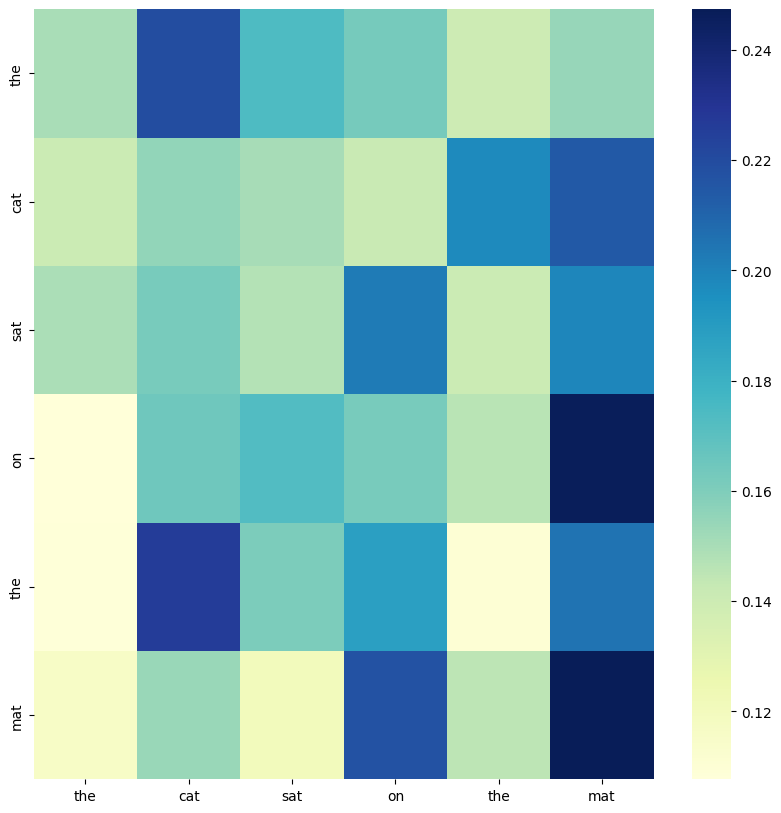

In [3]:
# 画出注意力权重的热图
plt.figure(figsize=(10,10))
seaborn.heatmap(attention[0].detach().numpy(), cmap="YlGnBu", xticklabels=sentence.split(), yticklabels=sentence.split())
plt.show()


## 概述
本次作业主要内容为：在CIFAR10图像分类数据集上训练卷积神经网络，使用PGD对网络进行对抗攻击。

**注:本次作业中若没有GPU环境，将代码中的‘cuda’全部替换为‘cpu’，可以减小训练的epoch**

### 对抗攻击
神经网络在图片分类任务上取得了很高的准确率，但研究表明它们的鲁棒性往往很差。通过对输入图片进行一个微小的扰动，可以在不影响图片视觉效果的前提下，让神经网络的分类准确率大幅下降。这种对模型进行攻击的方式称为**对抗攻击**，对应的扰动后的图片称为**对抗样本**。

根据模型是否可见，对抗攻击可以分为
- 白盒攻击（white-box attack）：攻击者知道模型的内部结构与参数，可以对输入数据求梯度来寻找对抗样本。
- 黑盒攻击（black-box attack）：攻击者不知道模型的内部结构与参数，仅可以调用模型获取对于给定输入的输出结果。

根据是否指定攻击后的分类类别，对抗攻击又可以分为
- 指向性攻击（labeled attack）：使模型将扰动后的输入分类为指定的错误类别。
- 非指向性攻击（unlabeled attack）：使模型将扰动后的输入分类为任一错误类别。

本次作业，我们主要研究白盒非指向性攻击。

大多数白盒攻击算法基于模型关于输入的梯度对输入进行扰动。这些算法将对抗攻击转化为求解这样一个优化问题：给定扰动量的限制$\epsilon$，最大化扰动后的损失函数$\mathcal{L}(x,y;\theta)$。例如，Fast Gradient Sign Method (FGSM) 沿着梯度的$l_{\infty}$范数方向进行一步扰动
$$x' = x + \epsilon \cdot \mathrm{sign}(\nabla_x \mathcal{L}(x,y;\theta))$$
Projected Gradient Descent (PGD) 可以看作是FGSM的多步迭代版本，其攻击方法为
$$x'_{t+1} = \mathrm{Clip}_{x,\epsilon}(x'_t + \alpha \cdot \mathrm{sign}(\nabla_x \mathcal{L}(x'_t,y;\theta))$$
其中$\mathrm{Clip}$操作限制扰动的无穷范数不超过$\epsilon$。

In [4]:
# 导入需要的包
import numpy as np
import random
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms

导入CIFAR10数据集

In [5]:
class CIFAR10():
    NUM_CLASSES = 10
    IMAGE_SIZE = [32, 32]
    IMAGE_CHANNELS = 3
    
    def __init__(self):
        transform = transforms.Compose([transforms.ToTensor()])
        self.load_dataset(transform)
    
    def load_dataset(self, transform):
        self.trainset = torchvision.datasets.CIFAR10(root="./data", transform=transform, download=True)
        self.testset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

## 1.1 实现卷积神经网络(2分)
注：实现一个简单的卷积神经网络，有基本的分类能力即可，不要求很高的准确率，本次作业的重点在对抗攻击上。

In [6]:
# TODO: 搭建卷积神经网络
class ConvNet(nn.Module):
    def __init__(self, **kwargs):
        super(ConvNet, self).__init__()
        n_classes = 10
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv4 = nn.Conv2d(256, 64, 4, 2, 1)
        self.fc = nn.Linear(256, n_classes)
        
    def forward(self, x):
        """
            x: 输入图片
        """
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x
        

## 1.2 补全训练函数(2分)

In [7]:
def train_step(model, train_loader, optimizer, criterion, device='cpu'):
    model.train()
    train_loss = 0
    for (data, label) in tqdm(train_loader):
        data, label = data.to(device), label.to(device)
        # TODO: 补全train_step函数
        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()
        train_loss += loss
        
    return train_loss / len(train_loader)

def test_step(model, test_loader, criterion, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            # TODO: 补全test_step函数
            logits = model(data)
            loss = criterion(logits, label)
            test_loss += loss 
            t = torch.argmax(logits, dim=1)
            correct += torch.sum(t == label).data.float()
            
    test_loss /= len(test_loader.dataset)
    print("Test Loss: {}, Accuracy: {}".format(test_loss, correct / len(test_loader.dataset)))

def train(model, train_loader, test_loader, optimizer, criterion, device='cpu', epochs=10):
    for epoch in range(epochs):
        train_loss = train_step(model, train_loader, optimizer, criterion, device)
        print("Epoch: {}, Train Loss: {}".format(epoch+1, train_loss))
        test_step(model, test_loader, criterion, device)

## 模型训练
可以自行调整学习率或者更换optimizer（不要消耗太多时间用来调参）

In [8]:
dataset = CIFAR10()
train_dataloader = DataLoader(dataset.trainset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset.testset, batch_size=64, shuffle=False)

model = ConvNet().to('cpu')
lr = 0.0002
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
train(model, train_dataloader, test_dataloader, optimizer, criterion, device='cpu', epochs=2)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 782/782 [01:17<00:00, 10.07it/s]


Epoch: 1, Train Loss: 1.8411084413528442
Test Loss: 0.027512293308973312, Accuracy: 0.39570000767707825


100%|██████████| 782/782 [01:16<00:00, 10.19it/s]


Epoch: 2, Train Loss: 1.7506558895111084
Test Loss: 0.02713494934141636, Accuracy: 0.4074999988079071


## 1.3 PGD对抗攻击(4分)
按照介绍中的公式，补全PGD攻击的函数

`实在写不出来可以参考`[链接](https://muyuuuu.github.io/2021/04/26/DNN-safe-basic/)

In [9]:
class PGD():
    """The PGD attack class
    """
    def __init__(self, model, eps=8 / 255, alpha=2 / 255, steps=4):
        """The init function of the PGD attack class

        Args:
            model (nn.Model): The model.
            eps (float, optional): The limit of the disturbance. Defaults to 8/255.
            alpha (float, optional): The magnitude of the disturbance. Defaults to 2/255.
            steps (int, optional): Number of iterations of the disturbance. Defaults to 4.
        """
        self.model = model
        self.eps = eps
        self.alpha = alpha
        self.steps = steps

    def forward(self, images, labels, loss_fn, device='cpu'):
        """The forward function of the PGD attack class

        Args:
            images (Tensor): The images.
            labels (Tensor): The labels.
            loss_fn (nn.function): The loss function.
            device (str, optional): The device to use. Defaults to 'cpu'.

        Returns:
            Tensor: Images that are used as attacks after adding scrambling.
        """
        self.images = images.to(device)
        self.labels = labels.to(device)
        # TODO: 补全对抗攻击的函数，返回添加扰动后的图片
        images = images.to(device)
        labels = labels.to(device)
        orig = images.data 
        for i in range(self.steps):
            images.requires_grad = True
            logits = model(images)
            model.zero_grad()
            loss = loss_fn(logits, labels)
            loss.backward()
            adv_images = images + self.alpha * images.grad.sign()
            delta = torch.clamp(adv_images - orig, -self.eps, self.eps)
            images = torch.clamp(orig + delta, 0.0, 1.0).detach_()
        self.images = images.to(device)
        self.labels = labels.to(device)
        
        return self.images

## 生成对抗样本
使用PGD生成对抗样本，调用Adversarial_example类生成对抗样本，注意指定dataloader，model，loss_fn参数

In [10]:
class Adversarial_examples(Dataset):
    """The Adversarial_examples Dataset.
    """
    def __init__(self, dataloader, model, loss_fn, eps=8 / 255, alpha=2 / 255, steps=4, device='cpu'):
        """The __init__ function of the Adversarial_examples Dataset.

        Args:
            test_dataloader (DataLoader): The dataloader of test dataset.
            model (nn.Module): The model to attack.
            loss_fn (_type_): The loss function.
            eps (float, optional): The limit of the disturbance. Defaults to 8/255.
            alpha (float, optional): The magnitude of the disturbance. Defaults to 2/255.
            steps (int, optional): Number of iterations of the disturbance. Defaults to 4.
            device (str, optional): The device to use. Defaults to 'cpu'.
        """
        self.adversarial_data = None
        self.lables = None
        pgd = PGD(model, eps=eps, alpha=alpha, steps=steps)
        for image, lable in tqdm(dataloader):
            data = pgd.forward(images=image, labels=lable,
                               loss_fn=loss_fn, device=device)
            if self.adversarial_data is None:
                self.adversarial_data = data.cpu()
            else:
                self.adversarial_data = torch.concat(
                    (self.adversarial_data, data.cpu()), dim=0)
            if self.lables is None:
                self.lables = lable.cpu()
            else:
                self.lables = torch.concat((self.lables, lable.cpu()), dim=0)

    def __len__(self):
        return len(self.adversarial_data)

    def __getitem__(self, index):
        return self.adversarial_data[index], self.lables[index]

使用test_data生成对抗样本，并创建对应的dataloader

In [11]:
Adversarial_examples_test_dataset = Adversarial_examples(test_dataloader, model, criterion, device='cpu')
Adversarial_examples_test_dataloader = DataLoader(Adversarial_examples_test_dataset, batch_size=64, shuffle=False)

100%|██████████| 157/157 [00:56<00:00,  2.79it/s]


查看生成的对抗样本和原始图片，可以看出对抗样本的视觉效果基本没有变化，但是模型的分类结果却发生了改变

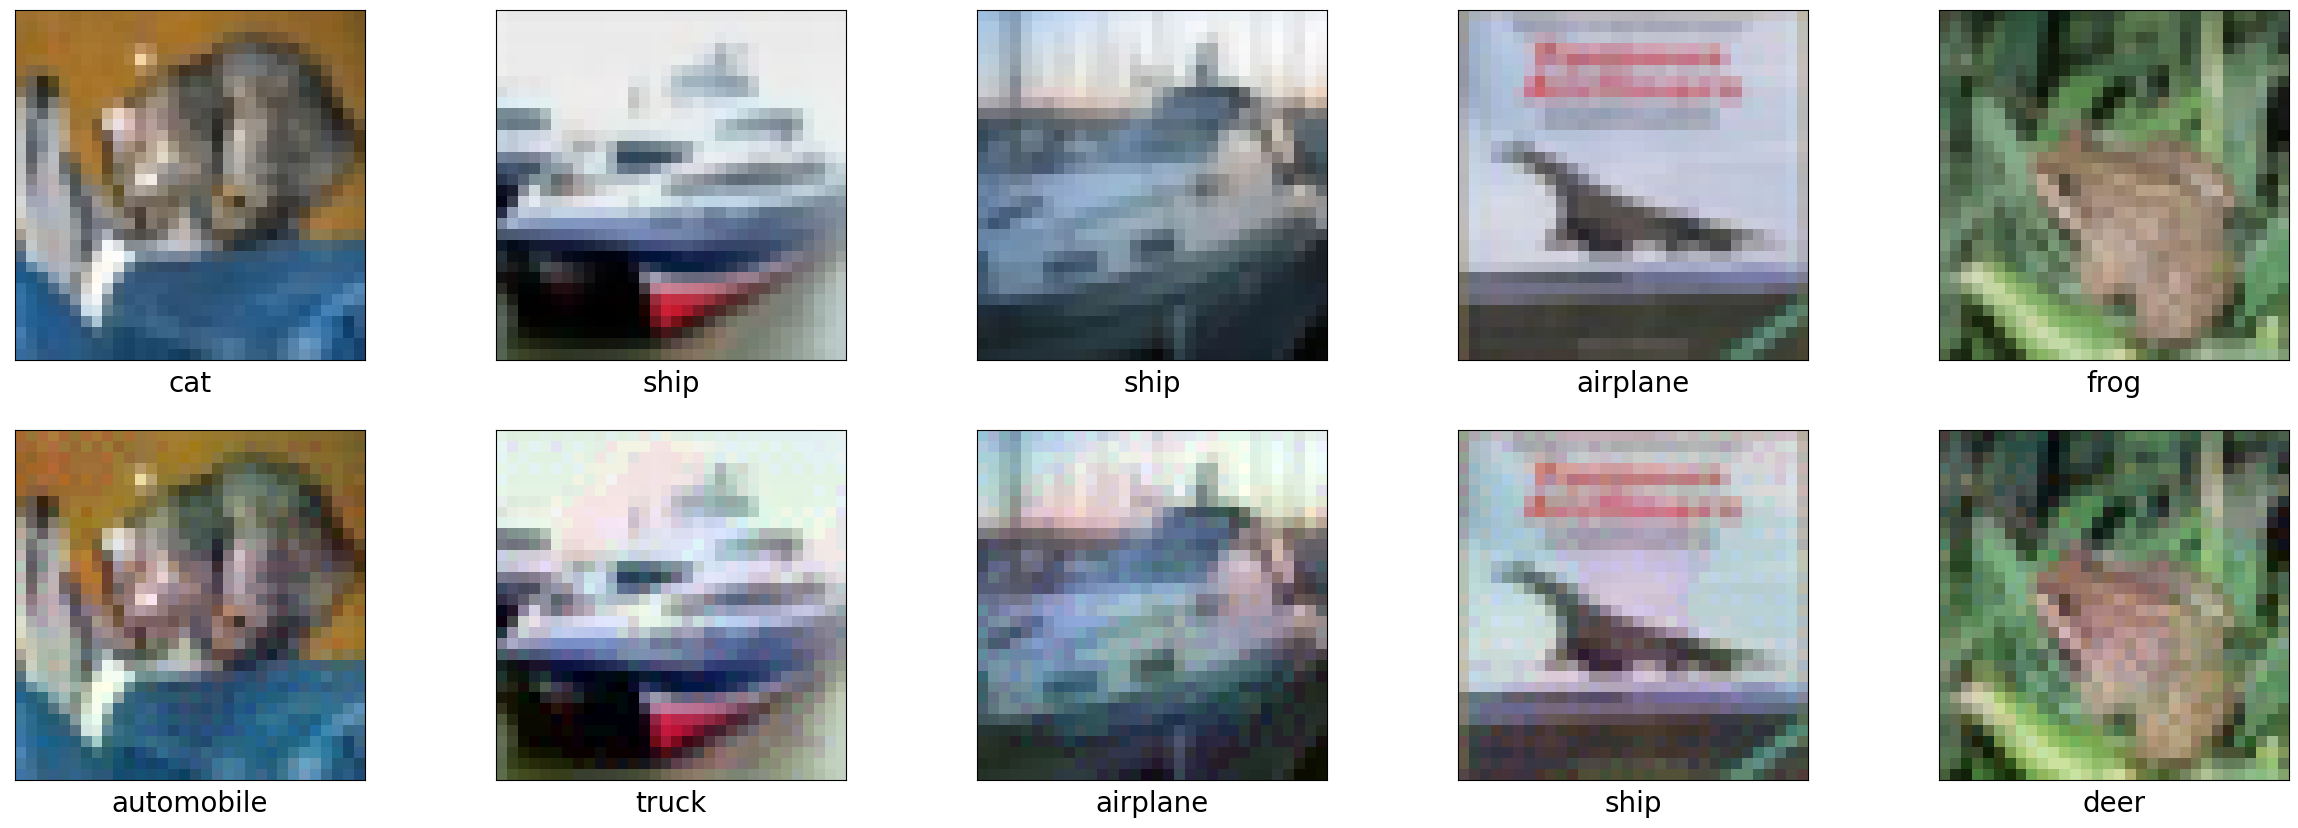

In [12]:
import matplotlib.pyplot as plt
import numpy as np
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
adv_images, adv_labels = next(iter(Adversarial_examples_test_dataloader))
pred_labels = model(adv_images.to('cpu')).argmax(dim=1)
adv_images = adv_images.numpy()
adv_labels = adv_labels.numpy()
adv_images = np.transpose(adv_images, (0, 2, 3, 1))
adv_labels = np.squeeze(adv_labels)
img, labels = next(iter(test_dataloader))
img = img.numpy()
img = np.clip(img, 0, 1)
labels = labels.numpy()
img = np.transpose(img, (0, 2, 3, 1))
labels = np.squeeze(labels)
plt.figure(figsize=(30, 10))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[i])
    plt.xlabel(text_labels[labels[i]], fontsize=20)
for i in range(5):
    plt.subplot(2, 5, 5+i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(adv_images[i])
    plt.xlabel(text_labels[pred_labels[i]], fontsize=20)
plt.show()

## 测试
使用对抗样本测试模型的准确率，可以看到准确率大幅下降

In [13]:
test_step(model, test_dataloader, criterion, device='cpu')
test_step(model, Adversarial_examples_test_dataloader, criterion, device='cpu')

Test Loss: 0.02713494934141636, Accuracy: 0.4074999988079071
Test Loss: 0.06685145944356918, Accuracy: 0.005100000184029341


## 1.4 计算attack成功率(2分)
补全evaluate函数，计算攻击成功率

In [14]:
# 计算attack成功率
def evaluate(model, test_loader, adv_loader, device='cpu'):
    model.eval()
    correct = 0
    attack_success = 0
    for (images, labels), (adv_images, adv_labels) in zip(test_loader, adv_loader):
        images = images.to(device)
        labels = labels.to(device)
        adv_images = adv_images.to(device)
        adv_labels = adv_labels.to(device)
        # TODO: 分别计算预测正确的数量和原来预测正确，攻击后预测错误的数量
        logits_pred = model(images)
        logits_adv_pred = model(adv_images)
        labels_pred = torch.argmax(logits_pred, dim=1)
        labels_pred_adv = torch.argmax(logits_adv_pred, dim=1)

        correct += torch.sum(labels_pred == labels).data.float()
        attack_success += torch.sum((labels_pred_adv != labels) & (labels_pred == labels))

    print('Attack Accuracy: %d %%' % (100 * attack_success/ correct))

evaluate(model, test_dataloader, Adversarial_examples_test_dataloader, device='cpu')

Attack Accuracy: 98 %


## 1.5 附加题: 防御措施(2分)
选择课件上的一种防御措施，或者自己认为有效的防御措施，实现防御措施并测试攻击成功率

In [ ]:
# TODO: